In [91]:
import torch
import utilities

dataDir = 'data'
modelsDir = 'models'

rawFname = 'combined.csv'
w2vFname = 'word2vec.bin'
pickleFname = 'dfPickles.p'

In [92]:
with open("models/BiRNN-2-256-38.pt", 'rb') as f:
    N = torch.load(f)
N.cuda()

BiRNN-2-256-38

In [93]:
N.cpu()

BiRNN-2-256-38

In [96]:
import gensim

In [97]:
gensim.__version__

'2.2.0'

In [95]:
N.save('.')

In [37]:
fullDF, w2v = utilities.preprocesing(dataDir, rawFname, modelsDir, w2vFname, pickleFname)
fullDF.index = fullDF['eid']
fullDF['abstract_vecs'] = fullDF['abstract_tokens'].apply(lambda x : utilities.genVecSeq(x, w2v))
fullDF['title_vecs'] = fullDF['title_tokens'].apply(lambda x : utilities.genVecSeq(x, w2v))

Loading W2V
Loading DF


In [38]:
trainingDF = pandas.read_csv('train.csv', index_col='eid')[['title']]
testingDF = pandas.read_csv('test.csv', index_col='eid')[['title']]
#fullDF = pandas.read_csv('data/combined.csv', index_col= 'eid')
testingDF = testingDF.join(fullDF, rsuffix='_full')
trainingDF = trainingDF.join(fullDF, rsuffix='_full')

In [47]:
regen = True

if regen:
    tDF = testingDF
    catsDict = {
        'title' : [],
        'eid' : [],
        'abstract' : [],
        'year' : [],
        'weightP' : [],
        'weightN' : [],
    }
    tstart = time.time()
    for i, (r_index, row) in enumerate(tDF.iterrows()):
        eta = (time.time() - tstart) / (i + 1) * (len(tDF) - i)
        print("{}: {:.1f}%, ETA {:.0f}m {:.1f}s".format(i,
                                                    i / len(tDF) * 100,
                                                    eta // 60,
                                                    eta % 60).ljust(80)
                                                  , end = '\r')
        try:
            abVec, tiVec, yVec = utilities.varsFromRow(row, w2v)
            out = N(abVec, tiVec)
        except Exception as e:
            print(e)
            print(row['eid'])
            continue
        catsDict['weightN'].append(out.data[0][0])
        catsDict['weightP'].append(out.data[0][1])
        catsDict['title'].append(row['title'])
        catsDict['eid'].append(row['eid'])
        catsDict['abstract'].append(row['abstract'])
        catsDict['year'].append(row['year'])
        #catsDict['source'].append(row['source'])
    dfY = pandas.DataFrame(catsDict)
    dfY['isCSS'] = dfY['weightP'] > dfY['weightN']
    dfY['is CSS'] = dfY['isCSS']
    dfY.to_csv('outputs/withYears.csv')
    print("Done".ljust(80))
else:
    dfY = pandas.read_csv('outputs/withYears.csv', index_col='eid')

In [62]:
dfY.index = dfY['eid']
dfY = dfY.join(testingDF['class'])

In [69]:
df_falseNeg = dfY[dfY['class'] == 1]
df_falseNeg = df_falseNeg[df_falseNeg['isCSS'] == False]

In [80]:
for i in range(10):
    row = df_falseNeg.iloc[i]
    eN = np.exp(row['weightN'])
    eP = np.exp(row['weightP'])
    pP = eP / (eN + eP)
    pN = eN / (eN + eP)
    print("N: {:.3f}, P: {:.3f}\tprobN: {:.3f}, probP: {:.3f}".format(row['weightN'], row['weightP'], pN, pP))
    print(row['title'])
    print(row['abstract'][:1000])
    print()

N: 1.331, P: -1.291	probN: 0.932, probP: 0.068
Emerging multiple issue e-auctions
Emerging multiple issue e-auctions. We review the emerging field of multiple issue e-auctions and discuss their design features and performance criteria. We primarily consider B2B transactions in a reverse auction, that is, a procurement setting. In traditional auctions, the matching of buyers and sellers is typically based just on price. However, when there are quality and other differences in the merchandise and differences in the terms of the transaction, which are common in Request for Quotes, additional issues besides price should be considered. Such multiple issue, multiple unit e-auctions/negotiations, and their characteristics are the focus of our paper. We also discuss the role that OR has played and undoubtedly will play in the design and implementation of such e-auctions.

N: 1.777, P: -1.879	probN: 0.975, probP: 0.025
Who trusts? Personality, trust and knowledge sharing
Who trusts? Personality

In [75]:
df_falsePos = dfY[dfY['class'] == 0]
df_falsePos = df_falsePos[df_falsePos['isCSS'] == True]

In [81]:
for i in range(10):
    row = df_falsePos.iloc[i]
    eN = np.exp(row['weightN'])
    eP = np.exp(row['weightP'])
    pP = eP / (eN + eP)
    pN = eN / (eN + eP)
    print("N: {:.3f}, P: {:.3f}\tprobN: {:.3f}, probP: {:.3f}".format(row['weightN'], row['weightP'], pN, pP))
    print(row['title'])
    print(row['abstract'][:1000])
    print()

N: -1.356, P: 1.311	probN: 0.065, probP: 0.935
Will the growth of multi-channel retailing diminish the pricing efficiency of the web?
Will the growth of multi-channel retailing diminish the pricing efficiency of the web?. In this study, we compare the pricing behavior between online branches of traditional retailers and pure Internet retailers. We seek to determine whether the pricing policies of these two types of online organizations differ, possibly because of the different competitive environments in which each operates. While both offer product over the Internet, traditional retailers must also taken into consideration the impact that such offers will have upon the business that they transact in their land-based stores. We anticipate that the constraint of a land-based store will cause such dual-channel operators to charge higher prices than Internet operators not so constrained. Focusing on standardized DVD brands, we gather a data set with of 4896 observations; we find that pric

In [82]:
df_truePos = dfY[dfY['class'] == 1]
df_truePos = df_truePos[df_truePos['isCSS'] == True]

In [83]:
for i in range(10):
    row = df_truePos.iloc[i]
    eN = np.exp(row['weightN'])
    eP = np.exp(row['weightP'])
    pP = eP / (eN + eP)
    pN = eN / (eN + eP)
    print("N: {:.3f}, P: {:.3f}\tprobN: {:.3f}, probP: {:.3f}".format(row['weightN'], row['weightP'], pN, pP))
    print(row['title'])
    print(row['abstract'][:1000])
    print()

N: -1.194, P: 1.183	probN: 0.085, probP: 0.915
The on-line auction phenomenon: Growth, strategies, promise, and problems
The on-line auction phenomenon: Growth, strategies, promise, and problems. Summarizing panel discussions between auction practitioners and researchers at Northwestern University, this essay reviews the recent growth of on-line auction sites and addresses some of their key benefits and costs. We also describe recent research on bidder behavior, focusing on bidder reactions to different auction mechanisms. We believe that there is immense potential for communication and collaboration between auction practitioners and researchers. Such dialogue could supply researchers timely, real-world auction data. Simultaneously, the on-line auction community would gain information about the mechanics of auction formats and their effects on bidder behavior.

N: -0.590, P: 0.588	probN: 0.235, probP: 0.765
Determinants of Internet Auction Success and Closing Price: An Exploratory Stud

In [84]:
def compareRows(rows, N, useTitle = True, w2v = None):
    fig, axes = plt.subplots(figsize = (20,25),
                             nrows = len(rows) + 1,
                             gridspec_kw = {'height_ratios': [5] * len(rows) + [1]})
    aLst = []
    for i, row in enumerate(rows):
        if 'title_vecs' in row:
            abVec, tiVec, yVec = utilities.varsFromRow(row)
        else:
            abVec, tiVec, yVec = utilities.varsFromRow(row, w2v)
        if useTitle:
            outLSTM, (h_n, c_n) = N.lstmTi(tiVec)
            s = row['title']
        else:
            outLSTM, (h_n, c_n) = N.lstmAb(abVec)
            s = row['abstract']
        out = N(abVec, tiVec)
        probNeg = np.exp(out.data[0][0])
        probPos = np.exp(out.data[0][1])            
        probNeg = probNeg / (probNeg + probPos)
        probPos = probPos / (probNeg + probPos)
        
        a = np.array(outLSTM.data.tolist())
        aLst.append(a[0, -1, :])
        #a = a[:,:100,:]
        df = pandas.DataFrame(a[0, :, :])
        df.index = nltk.word_tokenize(s)[:a.shape[1]]
        seaborn.heatmap(df, ax = axes[i], label='big')
        axes[i].set_title("Article Title: '{}'\n$P_{{negative}} = {:.4f}, P_{{positive}} = {:.4f}$".format(row['title'], probNeg, probPos), fontsize = 20)
        axes[i].set_xticklabels([])
        
    
    dfDiff = pandas.DataFrame(np.stack([aLst[0], np.fabs(aLst[0] - aLst[1]), aLst[1]]))
    dfDiff.index = ['Top', 'Diff', 'Bottom']
    seaborn.heatmap(dfDiff, ax = axes[-1], xticklabels = [i if i in np.linspace(0, len(dfDiff.columns) - 1, num = 10, dtype='int') else '' for i in range(len(dfDiff.columns))])
    axes[-1].set_title('Difference in Final Output Vectors', fontsize = 20)
    
    return fig, axes

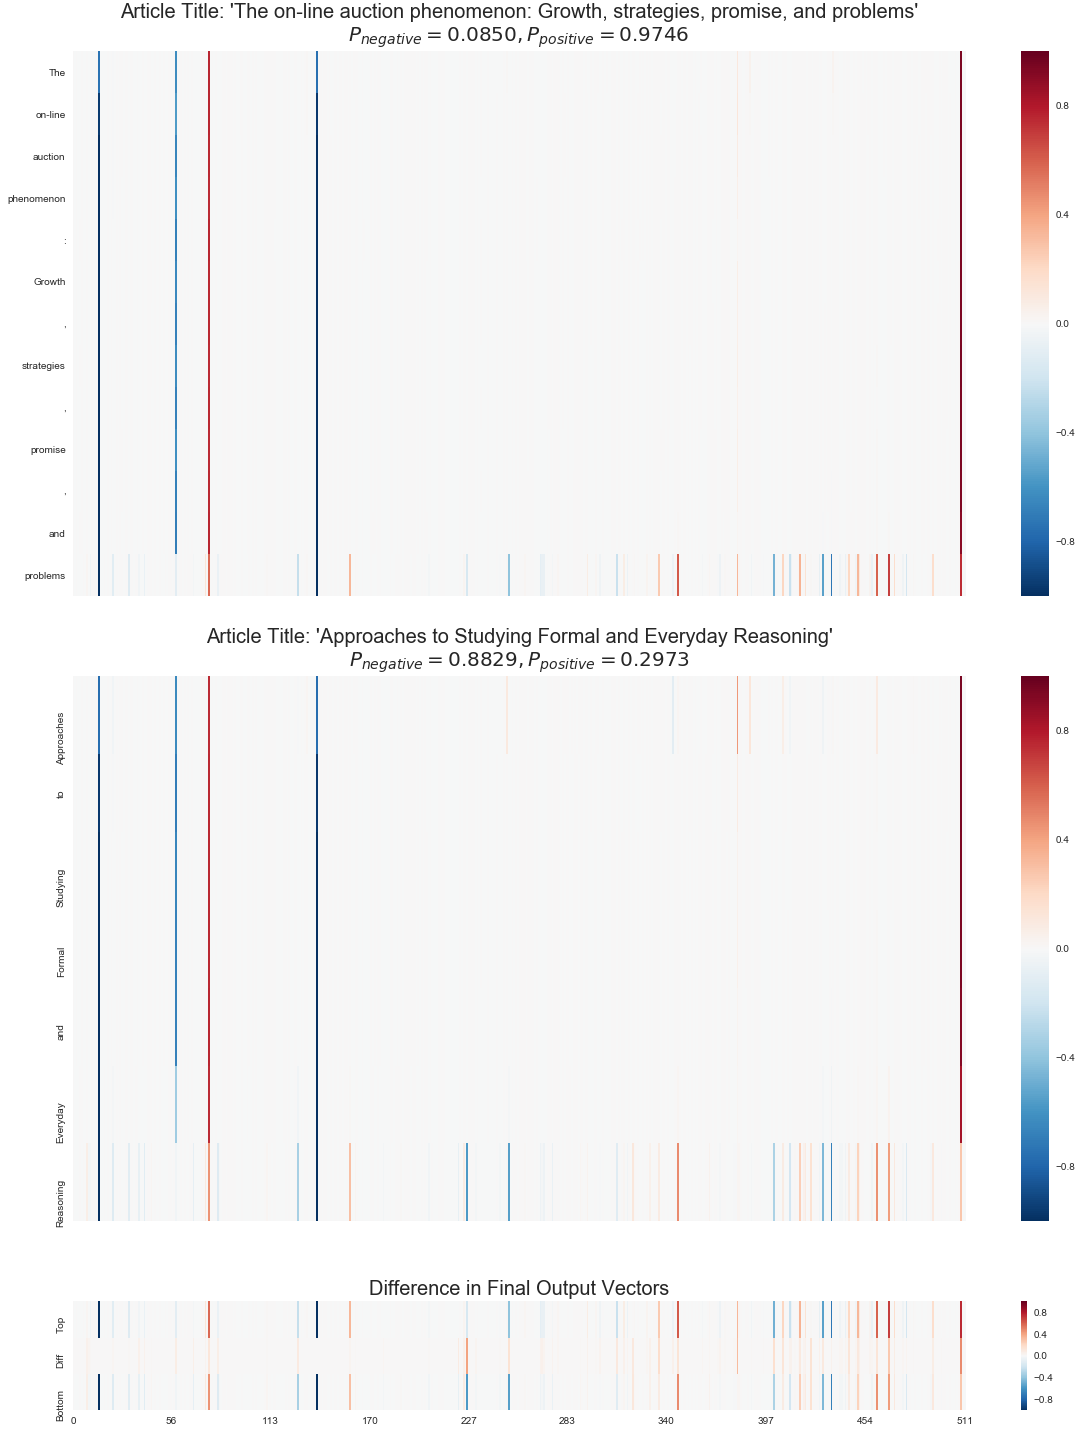

In [89]:
r1 = testingDF[testingDF['class'] == 1].iloc[0]
r2 = testingDF[testingDF['class'] == 0].iloc[0]
compareRows([r1, r2], N, w2v = w2v)
plt.show()

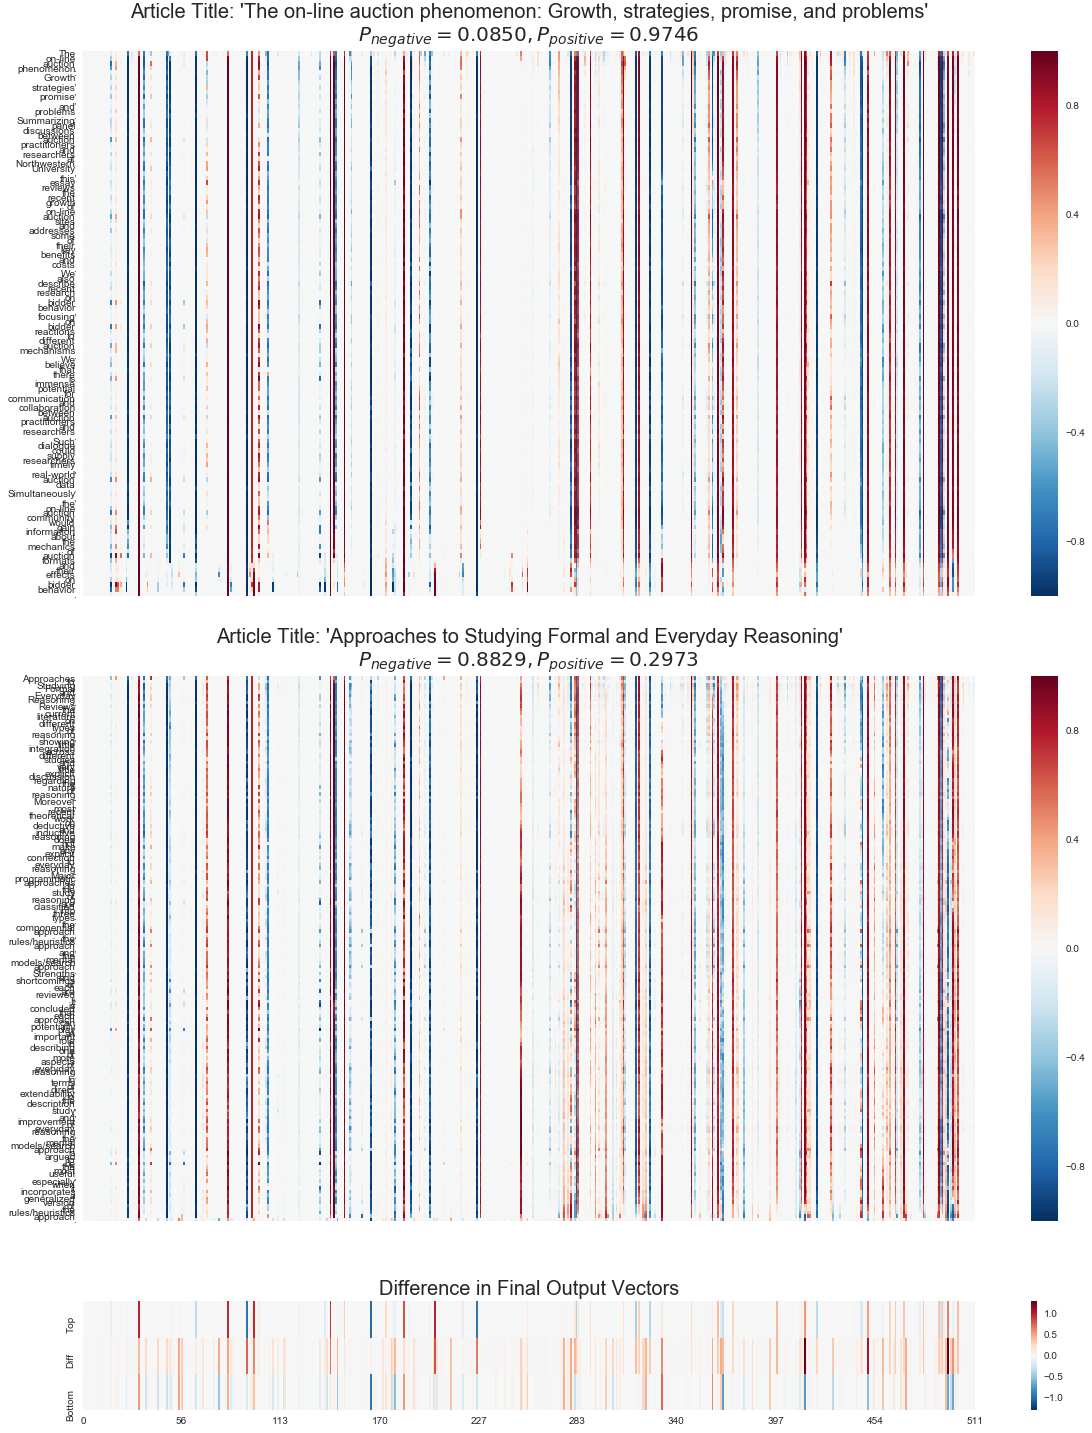

In [90]:
r1 = testingDF[testingDF['class'] == 1].iloc[0]
r2 = testingDF[testingDF['class'] == 0].iloc[0]
compareRows([r1, r2], N, w2v = w2v, useTitle=False)
plt.show()